# <center> Домашнее задание 4 </center>

## 1. Матрица Тёплица (30 баллов)

1. Напишите функцию, которая на вход принимает вектор уникальных значений {$a_{n-1},  \dots, a_{0}, \dots, a_{-(n+1)}$} и размер матрицы, а выдает сгенерированную на основании этих значений [матрицу Тёплица](https://en.wikipedia.org/wiki/Toeplitz_matrix). В решении нельзя использовать готовые реализации из ```scipy.linalg``` или других библиотек, но необходимо использовать ```numpy```. 
2. Напишите функцию, которая принимает на вход матрицу размера $N \times N$ и проверяет, является ли она матрицей Тёплица. Функция должна вернуть в ответе булевое значение (```True``` или ```False```). 

# 1)

In [6]:
import numpy as np

In [7]:
def makeToeplitz(vec, N):
    vec1 = np.array(vec[0: N-1])[::-1]
    vec2 = np.array(vec[N-1: len(vec)])
    mat = np.zeros((N, N))
    for i in range(N):
        mat[i] = np.append(vec1[:i][::-1], vec2[:len(vec2)-i], axis=0)
    return mat

In [8]:
makeToeplitz([1, 2, 5, 6, 7, 8, 6], 4)

array([[6., 7., 8., 6.],
       [5., 6., 7., 8.],
       [2., 5., 6., 7.],
       [1., 2., 5., 6.]])

# 2)

In [4]:
def checkDiagonal(mat, i, j):
    N=len(mat[0])
    res = mat[i][j]
    i += 1
    j += 1
    while (i < N and j < N):
        if (mat[i][j] != res):
            return False
        i += 1
        j += 1
    return True


def isToeplitz(mat):
    N=len(mat[0])
    for j in range(N):
        if not(checkDiagonal(mat, 0, j)):
            return False
    for i in range(1, N): 
        if not(checkDiagonal(mat, i, 0)):
            return False
    return True

In [5]:
isToeplitz([[6, 7, 8, 9],

            [4, 6, 7, 8],

            [1, 4, 6, 7],

            [0, 1, 4, 6]])

True

In [6]:
isToeplitz([[10, 7, 8, 9],

            [4, 6, 7, 8],

            [3, 4, 4, 7],

            [0, 1, 4, 6]])

False

## 2. Ищем лучшую однушку на ЦИАНе (35 баллов)

В этом задании будем скачивать объявления о продаже однокомнатных квартир в Москве c [ЦИАНа](https://www.cian.ru/cat.php?deal_type=sale&engine_version=2&offer_type=flat&p=1&region=1&room1=1) и выберем самую понравившуюся из них! :3

1. Напишите функцию, которая парсит все объявления с одной страницы и по каждому из них сохраняет ссылку (href) на объявление с более подробной информацией. Примените эту функцию для первых 10 страниц, сохранив все href в одном списке. Если хотите собрать полную информацию и не боитесь быть забаненными, можете скачать все 54 страницы.

2. Напишите функцию, которая для каждой (href) страницы с объявлением квартиры качает и сохраняет: 
* **Общую стоимость**
* **Адрес**
* **Ближайшее метро**
* **Тип жилья**
* **Площадь комнат**
* **Этаж**
* **Срок сдачи**

Сохраните эту информацию в DataFrame.

3. Избавьтесь от лишних символов в колонках с ценой квартиры, этажом и площадью комнат, приведя их к числову типу. Определите пороги по этим переменным, ниже или выше которых вы будете считать это жилье неподходящим. Например, цена не более 15 миллионов, этаж не ниже 2, общая площадь не менее 40 $м^2$. Можете выбрать другие наиболее важные для вас критерии, всего их должно быть не меньше 3. 
Отфильтруйте DataFrame, оставив только те объявления, которые удовлетворяют условиям. Отсортируйте оставшиеся объявления по возрастанию цены и отобразить топ-10 финальных кандидатов. Понравилась какая-нибудь квартира из них? :) 

In [9]:
import requests
import re
import pandas as pd

# 1)

In [11]:
def get_href_list(page_number=10):
    href_list = []
    for p in range(1, page_number + 1):
        href = requests.get(f'https://www.cian.ru/cat.php?deal_type=sale&engine_version=2&offer_type=flat&'
                            'p={p}&region=1&room1=1').text
        href_list += re.findall(r'https://www.cian.ru/sale/flat/\d+', href)
    return href_list

# 2)

In [12]:
def get_data():
    data = {}
    for href in get_href_list():
        print(href)
        text = requests.get(href).text
        price = int(re.findall(r'itemProp="price" content="([\d\s]+)', text)[0].replace(' ', ''))
        link = href
        if 'link' not in data:
            data['link'] = [link]
        else:
            data['link'].append(link)
        if 'price, rub' not in data:
            data['price, rub'] = [price]
        else: 
            data['price, rub'].append(price)
        address = re.findall(r'<meta name="twitter:description" content=["](.*?)["]', text)[0]
        if 'address' not in data:
            data['address'] = [address]
        else:
            data['address'].append(address)
        station = re.findall(r'title="метро (\D+?)"', text)[0]
        if 'metro_station' not in data:
            data['metro_station'] = [station]
        else:
            data['metro_station'].append(station)
        type_ = re.findall(r'Тип жилья</span><span class="a10a3f92e9--value--3Ftu5">(\D+?)<', text)[0]
        if "type" not in data:
            data["type"] = [type_]
        else:
            data['type'].append(type_)
        size = float(re.findall(r'"totalArea":["](.*?)["]', text)[0])
        if 'size, m^2' not in data:
            data['size, m^2'] = [size]
        else:
            data['size, m^2'].append(size)
        floor = int(re.findall(r'этаж (.+?)[/]', text)[0])
        if 'floor' not in data:
            data['floor'] = [floor]
        else:
            data['floor'].append(floor)  
        term = re.findall(r'Этаж</div></div><div class="a10a3f92e9--info--3XiXi"><div class="a10a3f92e9--info-value--18c8R">(.+?)<', text)
        if len(term) == 0:
            term = 'не указано'
        else:
            term = None
        if 'term' not in data:
            data['term'] = [term]
        else:
            data['term'].append(term)
    return data

In [21]:
df = pd.DataFrame(get_data())

# 3)

In [22]:
df.head()

""


In [377]:
df.dtypes

ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_0                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default.payment.next.month      int64
dtype: object

In [219]:
new_df = df[df['price, rub'] < 10000000][df['floor'] > 3][df['floor'] < 10][df['size'] < 40]
new_df.sort_values(by=['price'])

<ipython-input-219-a04092964f1e>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_df = df[df['price'] < 10000000][df['floor'] > 3][df['floor'] < 10][df['size'] < 40]


,price,address,station,type,size,floor,term
132,6806640,"Москва, НАО (Новомосковский), Сосенское поселе...",Филатов Луг,Новостройка,35.9,8,3 кв. 2022
244,6806640,"Москва, НАО (Новомосковский), Сосенское поселе...",Филатов Луг,Новостройка,35.9,8,3 кв. 2022
216,6806640,"Москва, НАО (Новомосковский), Сосенское поселе...",Филатов Луг,Новостройка,35.9,8,3 кв. 2022
188,6806640,"Москва, НАО (Новомосковский), Сосенское поселе...",Филатов Луг,Новостройка,35.9,8,3 кв. 2022
160,6806640,"Москва, НАО (Новомосковский), Сосенское поселе...",Филатов Луг,Новостройка,35.9,8,3 кв. 2022
104,6806640,"Москва, НАО (Новомосковский), Сосенское поселе...",Филатов Луг,Новостройка,35.9,8,3 кв. 2022
76,6806640,"Москва, НАО (Новомосковский), Сосенское поселе...",Филатов Луг,Новостройка,35.9,8,3 кв. 2022
272,6806640,"Москва, НАО (Новомосковский), Сосенское поселе...",Филатов Луг,Новостройка,35.9,8,3 кв. 2022
48,6806640,"Москва, НАО (Новомосковский), Сосенское поселе...",Филатов Луг,Новостройка,35.9,8,3 кв. 2022
20,6806640,"Москва, НАО (Новомосковский), Сосенское поселе...",Филатов Луг,Новостройка,35.9,8,3 кв. 2022



## 3. Дефолты (35 баллов)

Судя по стоимости недвижимости в Москве, придется влезть в долги... Проанализируем, как часто люди не отдают ипотеки и кредиты! 

В файле ```defaults.csv``` предоставлены данные, которые можно использовать для анализа клиентской базы, предсказания дефолта, кредитного скоринга (т.е. для оценки кредитных рисков клиентов). 

Переменные:
* **ID** - идентификатор клиента;
* **LIMIT_BAL** - сумма предоставленного кредита/ипотеки (в долларах);
* **SEX** - пол (1=мужской, 2=женский);
* **EDUCATION** - уровень образования (1=научная степень, 2=высшее, 3=среднее, 4=другое, 5 и 6=неизвестно);
* **MARRIAGE** - семейное положение (1=женат/замужем, 2=холост/незамужняя, 3=другое);
* **AGE** - возраст (в годах);
* **PAY_0** - Статус погашения кредита в сентябре (-1 = надлежащая оплата, 1 = задержка платежа на один месяц, 2 = задержка платежа на два месяца, ... 8 = задержка платежа на восемь месяцев, 9 = задержка платежа на девять месяцев и более). **PAY_2, PAY_3, ..., PAY_6** - в августе, июле, июне, мае и апреле соответственно;
* **BILL_AMT1** - Сумма выписки по счету в сентябре (в долларах). **BILL_AMT2, BILL_AMT3, ..., BILL_AMT6** - в августе, июле, июне, мае и апреле соответственно;
* **PAY_AMT1** - Сумма предыдущего платежа в сентябре (в долларах). **PAY_AMT1, PAY_AMT2, ..., PAY_AMT6** - в августе, июле, июне, мае и апреле соответственно;
* **default.payment.next.month**: произошел дефолт (1=да, 0=нет).

Нужно проанализировать набор данных банка, выполнив следующие задания:
1. Загрузить данные и преобразуйте в pd.DataFrame. Какого размера этот датасет? Посмотрите на первые 10 строк ваших данных. С помощью ```random.randint()``` в диапазоне значений индексов строк сгенерируйте случайное число $N$ и верните строки из датафрейма по индексам от $N$ до $N + 20$.<br>
2. Отобразите количество пропущенных значений во всех колонках.  <br>
3. Выведите количество уникальных клиентов в датасете, покажите не менее 2 разных способов это сделать. <br>
4. Проверьте, есть ли среди клиентов дисбаланс в количестве женщин и мужчин? Какого их соотношение (в процентах)? <br>
5. Создайте новую переменную **AGE_BINS** с категориями по переменной возраст (= возрастными диапазонами). Постройте и сравните графики распределения клиентов по значениям переменных *AGE* и *AGE_BINS*. Клиенты каких возрастов чаще всего приходят за кредитом в этот банк? Есть ли преимущество использования переменной c категориям? <br>
6. Выведите общее количество клиентов с дефолтом и без него. Постройте гистограмму с процентным отношением этих групп. Как можно оценить, велика ли полученная доля клиентов с дефолтом? <br>
7. Постройте гистограмму и график плотности распределения по суммам предоставленных кредитов (*LIMIT_BAL*) для каждой из групп клиентов отдельно (с дефолтом и без), поместив их на один график. Сделайте размер графика побольше, поменяйте дефолтные цвета. 
8. На основе графика из предыдущего пункта, ответьте на вопросы:
* По кредитам какого размера чаще всего происходят дефолты?
* На основе графиков плотности распределения, начиная от какой суммы кредита клиентов без дефолта становится больше, чем клиентов с дефолтом? 
* Как по графику определить, есть ли такие одобренные суммы кредитов, по которым никогда не происходит дефолт? Выведите значения а) сумм кредитов, по которым всегда встречается дефолт, б) и те, по которым никогда не бывает дефолта. <br>
9. Постройте матрицу корреляций для всех переменных по статусу погашения кредита. Добавьте значения корреляций на график. Есть ли общий тренд по возрастанию/убыванию корреляции по времени (всем месяцам)? <br>
10. Напишите функцию, которая возвращает словарь, где ключ - это сумма одобренного кредита, а значение - это вложенный словарь. В нем по ключу ```ratio``` хранится отношение клиентов с дефолтом к тем, у кого его не было, с такой суммой кредитов, а по ключу ```num_clients```  - общее число клиентов с таким кредитом. Пример элемента словаря: ``` {50000.0 : {'ratio': 0.357, 'num_clients': 3365}```. Отсортируйте получившийся словарь по ключу ```ratio``` в убывающем порядке. У какого размера кредита наибольшая доля клиентов с дефолтом? А сколько в датасете клиентов, по которым посчитана эта доля? Можем ли мы сделать вывод, что в целом не стоит одобрять эту сумму для кредита новым клиентам? <br>

Важно! Каждый график должен содержать как минимум заголовок и подписанные оси. 

# 1)

In [32]:
import random
df = pd.read_csv('defaults.csv')
print('shape: ', df.shape)
print(df.head(10))
n = random.randint(df.index[0], df.index[-1])
df[n:n+20]

shape:  (30000, 25)
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   
5   6    50000.0    1          1         2   37      0      0      0      0   
6   7   500000.0    1          1         2   29      0      0      0      0   
7   8   100000.0    2          2         2   23      0     -1     -1      0   
8   9   140000.0    2          3         1   28      0      0      2      0   
9  10    20000.0    1          3         2   35     -2     -2     -2     -2   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...        0.0        0.0        0

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
2750,2751,260000.0,2,1,1,32,-1,-1,2,-1,...,1732.0,718.0,165.0,2268.0,0.0,1732.0,718.0,165.0,3735.0,0
2751,2752,360000.0,2,2,2,39,-1,2,2,-2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2752,2753,30000.0,2,3,1,36,0,0,0,0,...,10180.0,10394.0,9614.0,1321.0,1451.0,349.0,362.0,343.0,356.0,1
2753,2754,30000.0,2,2,2,22,0,0,0,2,...,28392.0,22612.0,22750.0,2000.0,1800.0,0.0,1000.0,1000.0,0.0,1
2754,2755,20000.0,1,1,2,22,0,0,0,0,...,5751.0,6500.0,7386.0,1100.0,1100.0,500.0,1000.0,1000.0,1000.0,0
2755,2756,240000.0,2,2,2,25,0,0,0,0,...,186275.0,190337.0,193961.0,6500.0,7000.0,6680.0,7070.0,6954.0,14870.0,0
2756,2757,200000.0,1,2,1,31,7,6,5,4,...,217600.0,208432.0,200057.0,0.0,328.0,0.0,0.0,600.0,2500.0,1
2757,2758,70000.0,1,2,2,38,0,0,2,0,...,30148.0,29918.0,29399.0,5600.0,0.0,1500.0,1057.0,2000.0,1035.0,0
2758,2759,200000.0,2,1,2,23,-2,-2,-2,-2,...,488.0,0.0,1915.0,878.0,488.0,488.0,0.0,1915.0,100.0,0
2759,2760,150000.0,2,1,2,31,-1,-1,-1,0,...,129691.0,88173.0,63034.0,312.0,20132.0,129665.0,127.0,315.0,0.0,0


# 2)

In [33]:
for col in df:
    print(col, len(df[col][df[col].isnull() == True]))

ID 0
LIMIT_BAL 0
SEX 0
EDUCATION 0
MARRIAGE 0
AGE 0
PAY_0 0
PAY_2 0
PAY_3 0
PAY_4 0
PAY_5 0
PAY_6 0
BILL_AMT1 0
BILL_AMT2 0
BILL_AMT3 0
BILL_AMT4 0
BILL_AMT5 0
BILL_AMT6 0
PAY_AMT1 0
PAY_AMT2 0
PAY_AMT3 0
PAY_AMT4 0
PAY_AMT5 0
PAY_AMT6 0
default.payment.next.month 0


# 3)

In [34]:
len(df['ID'].unique())

30000

# 4)

In [35]:
len(df[df['SEX'] == 1]), len(df[df['SEX'] == 2]), len(df[df['SEX'] == 1])/len(df)

(11888, 18112, 0.39626666666666666)

11888 мужчин, 18112 женщин,  39 % мужчин

# 5)

In [36]:
import seaborn as sns

In [37]:
AGE_BINS = {        '<25' : len(df[df['AGE'] < 25]),
                    '25< <45': len(df[df['AGE'] > 25][df['AGE'] < 45]),
                    '45< <60': len(df[df['AGE'] > 45][df['AGE'] < 60]),
                     '>60': len(df[df['AGE'] > 60]),
            }
AGE_BINS

<ipython-input-37-743b79f5a11b>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  '25< <45': len(df[df['AGE'] > 25][df['AGE'] < 45]),
<ipython-input-37-743b79f5a11b>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  '45< <60': len(df[df['AGE'] > 45][df['AGE'] < 60]),


{'<25': 2685, '25< <45': 20843, '45< <60': 4330, '>60': 272}

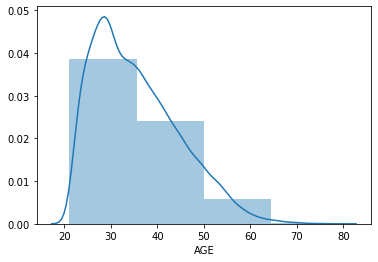

In [38]:
sns.distplot(df['AGE'], bins=4)

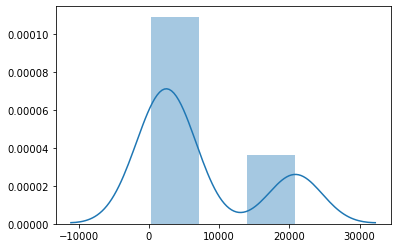

In [39]:
sns.distplot(pd.Series(AGE_BINS))

больше всего людей в категории 25-45: 20843

# 6)

In [40]:
print(len(df[df['default.payment.next.month'] == 1]), ' - default')
print(len(df[df['default.payment.next.month'] == 0]), ' - not default')
print(len(df[df['default.payment.next.month'] == 1])*100/len(df), ' - % of defaults')

6636  - default
23364  - not default
22.12  - % of defaults


C:\Users\lixak\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


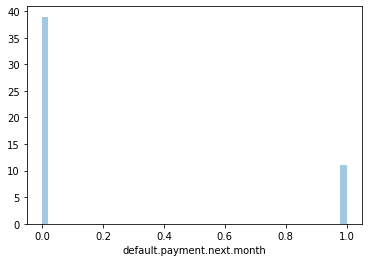

In [41]:
sns.distplot(df['default.payment.next.month'])

22% процента дефолтов

# 7)

In [42]:
import matplotlib.pyplot as plt

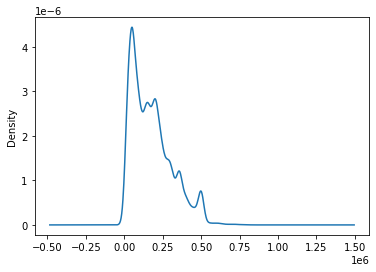

In [43]:
df[df['default.payment.next.month'] == 0]['LIMIT_BAL'].plot.kde()

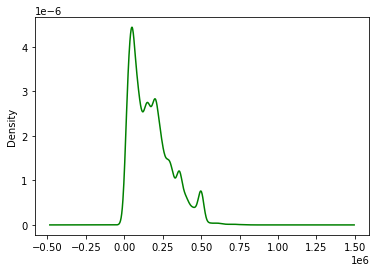

In [44]:
df[df['default.payment.next.month'] == 0]['LIMIT_BAL'].plot.kde(color= 'g')

Text(0.5, 1.0, 'not defaults')

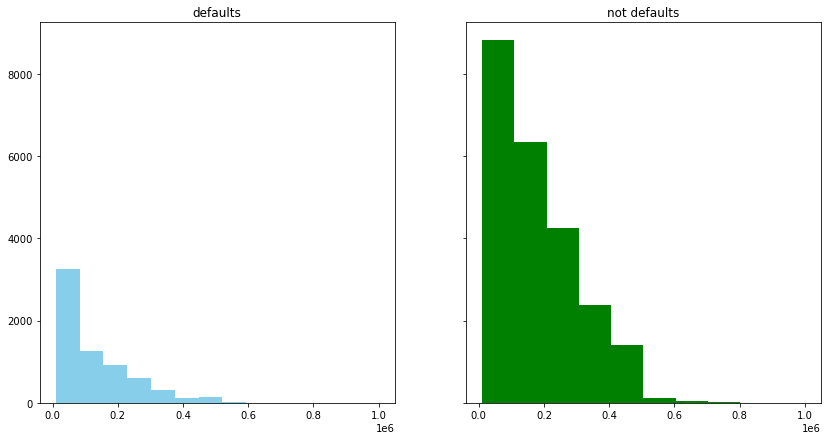

In [45]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,  sharex=True,figsize=(14, 7))
ax1.hist(df[df['default.payment.next.month'] == 1]['LIMIT_BAL'], color = "skyblue")
ax1.set_title('defaults')
ax2.hist(df[df['default.payment.next.month'] == 0]['LIMIT_BAL'], color= 'g')
ax2.set_title('not defaults')

# 8, 9)

по кредитам в размере около 50000 происходят дефолты

# 10)

Начиная с суммы кредита болеее 100000 клиентов с кредитом без дефолта становиться больше, чем с ним

# 11)

In [46]:
for credit in df["LIMIT_BAL"]:
    if len(df[df['default.payment.next.month'] == 0][df['LIMIT_BAL'] == credit]) == 0:
        print(credit)

<ipython-input-46-6ec31a1ffb3b>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if len(df[df['default.payment.next.month'] == 0][df['LIMIT_BAL'] == credit]) == 0:


327680.0


a) из пункта 11, суммы на которых у всех клиентов случается дефолт: 327680
б) по суммам более 800000 никогда не бывает дефолта (исходя из гистограммы дефолтов)

# 12)

In [47]:
df.corr

<bound method DataFrame.corr of           ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
0          1    20000.0    2          2         1   24      2      2     -1   
1          2   120000.0    2          2         2   26     -1      2      0   
2          3    90000.0    2          2         2   34      0      0      0   
3          4    50000.0    2          2         1   37      0      0      0   
4          5    50000.0    1          2         1   57     -1      0     -1   
...      ...        ...  ...        ...       ...  ...    ...    ...    ...   
29995  29996   220000.0    1          3         1   39      0      0      0   
29996  29997   150000.0    1          3         2   43     -1     -1     -1   
29997  29998    30000.0    1          2         2   37      4      3      2   
29998  29999    80000.0    1          3         1   41      1     -1      0   
29999  30000    50000.0    1          2         1   46      0      0      0   

       PAY_4  ...  

# 13)

In [48]:
def get_dict():
    dict_ = {}
    for credit in df['LIMIT_BAL']:
        try:
            ratio = len(df[df['default.payment.next.month'] == 1][df['LIMIT_BAL'] == credit])/(len(df[df['default.payment.next.month'] == 0][df['LIMIT_BAL'] == credit]) + 0.0000001)
        except 'ZeroDivisionError':
            print(credit, " - кредит на котором у всех дефолты")
        num_clients = len(df[df['LIMIT_BAL'] == credit])
        dict_[credit] = {'ratio': ratio, 'num_clients': num_clients}
    return dict_

In [49]:
dict_ = get_dict()

<ipython-input-48-98072c366966>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df[df['default.payment.next.month'] == 1][df['LIMIT_BAL'] == credit])/(len(df[df['default.payment.next.month'] == 0][df['LIMIT_BAL'] == credit]) + 0.0000001)


In [50]:
dict_

{20000.0: {'ratio': 0.5461658841513172, 'num_clients': 1976},
 120000.0: {'ratio': 0.32723948805717745, 'num_clients': 726},
 90000.0: {'ratio': 0.34226804116654264, 'num_clients': 651},
 50000.0: {'ratio': 0.3568548386952881, 'num_clients': 3365},
 500000.0: {'ratio': 0.12636505458247035, 'num_clients': 722},
 100000.0: {'ratio': 0.35051546387235627, 'num_clients': 1048},
 140000.0: {'ratio': 0.2936096717973041, 'num_clients': 749},
 200000.0: {'ratio': 0.2146263910799184, 'num_clients': 1528},
 260000.0: {'ratio': 0.20046082944689841, 'num_clients': 521},
 630000.0: {'ratio': 0.16666666388888893, 'num_clients': 7},
 70000.0: {'ratio': 0.4030710171971073, 'num_clients': 731},
 250000.0: {'ratio': 0.17056856181586336, 'num_clients': 350},
 320000.0: {'ratio': 0.16417910441635106, 'num_clients': 312},
 360000.0: {'ratio': 0.21182943600937698, 'num_clients': 881},
 180000.0: {'ratio': 0.21489621486997604, 'num_clients': 995},
 130000.0: {'ratio': 0.27447552442753925, 'num_clients': 729},

## *4. Друзья друзей (бонусное, 30 баллов) 

1. С помощью VK API скачайте id всех ваших друзей. Убедитесь, что у вас открытый аккаунт, иначе будет ошибка доступа, и ничего скачать не удастся. Если вы не хотите открывать аккаунт, можете выбрать другой (например, аккаунт какой-то известной личности). 
2. Напишите функцию, которая с помощью ```users.get``` и ```friends.get``` по каждому человеку из списка друзей скачивает имя, фамилию, пол, город, дату рождения, образование, количество друзей. Напишите исключение, если у друга закрытый аккаунт, чтобы не включать его в анализ и функция не ломалась. 
3. Постройте график распределения количества друзей по всем друзьям. Создайте переменную ```friends_count_cat```, которая на основе количество друзей принимает значения $1$ - если друзей мало, $2$ - средне, $3$ - много друзей. Определите диапазоны для этих значений на основе графика с распределением. Постройте гистограмму по новой переменной. 
4. Разбейте колонку с образованием на две колонки ```university``` и ```faculty```, в первой сохранив название университета, во второй - название факультета. Удалите исходную колонку с образованием. Сгруппируйте данные по полу и постройте для каждой из групп на одном графике распределения 1) по городам, 2) университету, 3) факультету. Какие наблюдаются различия по этим переменным между девушками и молодыми людьми? 

In [51]:
import vk_api

In [52]:
token = '8e3b96a88e3b96a88e3b96a8d38e4efb5f88e3b8e3b96a8d1e807952a1099cbd707c938'
vk_session = vk_api.VkApi('89771301704', 'serutu17', token=token)
vk_session.auth()
vk = vk_session.get_api()
ids = vk.friends.get()['items']

In [53]:
dfdict = {'first_name':[],
         'last_name': [],
         'sex': [],
         'city': [],
         'bdate': [],
         'university': [],
         'friends': []}
for id_ in ids:
    try:
        data = vk.users.get(user_ids=id_, fields=['sex', 'bdate', 'city', 'education', 'counters'])
        if 'first_name' not in data[0]:
            dfdict['first_name'].append('')
        else:
            dfdict['first_name'].append(data[0]['first_name'])
        if 'last_name' not in data[0]:
            dfdict['last_name'].append('')
        else:
            dfdict['last_name'].append(data[0]['last_name'])
        if 'sex' not in data[0]:
            dfdict['sex'].append('')
        else:
            dfdict['sex'].append(data[0]['sex'])
        if 'city' not in data[0]:
            dfdict['city'].append('')
        else:
            dfdict['city'].append(data[0]['city']['title'])
        if 'university_name' not in data[0]:
             dfdict['university'].append('')
        else:
            dfdict['university'].append(data[0]['university_name'])
        if 'bdate' not in data[0]:
            dfdict['bdate'].append('')
        else:
            dfdict['bdate'].append(data[0]['bdate'])
        if 'counters' not in data[0]:
            dfdict['friends'].append(0)
        else:
            dfdict['friends'].append(int(data[0]['counters']['friends']))
    except KeyError:
        pass

In [54]:
df = pd.DataFrame(dfdict)
df.head()

,first_name,last_name,sex,city,bdate,university,friends
0,Evgenia,Gorobets,1,Moscow,,Open College of the Arts (OCA),5752
1,Artem,Emelyanov,2,Moscow,12.7.1976,МИЭМ,373
2,Polya,Kuznechik,1,Moscow,,,120
3,Endzhe,Daminova,1,Moscow,,,624
4,Ilyas,Gasanov,2,Moscow,27.7,НИУ ВШЭ (ГУ-ВШЭ),250


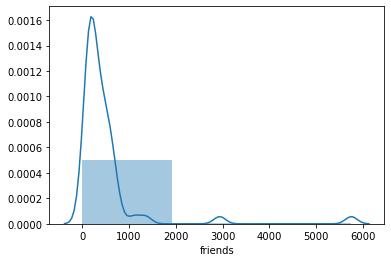

In [55]:
sns.distplot(df['friends'], bins=3)

на этом графике также привидена гистограмма для трех разделений 
при перезапуске kernel, циан забанил мой ip и выдавал ошибку на get запросах, прошу запустить код 2 задания с вашего пк